# Gray-Level Co-occurance Matrix (GLCM)

A gray-level co-occurrence matrix (GLCM) is a statistical method of examining texture that considers the spatial relationship of pixels. The texture of an image is characterized by how often pairs of pixel with specific values and in a specified spatial relationships occur in an image.

Texture usually improves classification accuracy. In the case of cocoa agroforestry, a texture analysis can be helpful for detecting shrub crops under forest canopies and can differentiate crops such as cocoa, rubber and oil palm (Abu et al 2021). 

This notebook explores GLCM implementation. The selection of GLCM properties and appropriate parameters are based on the findings of the following studies.
* Numbisi et al (2019)
* Abu et al (2021)
* Descals et al (2019)
* Maskell et al (2021)

In [3]:
import skimage 
from skimage.util import img_as_ubyte
from skimage import data
from skimage.feature import graycomatrix, graycoprops
import rasterio as rs
from rasterio.plot import show
import hickle as hkl
import os
import scipy
from scipy import ndimage
import matplotlib.pyplot as plt
import itertools
import seaborn as sns
import sys
import pandas as pd
from tqdm import tqdm

sys.path.append('../src/')
import ptype_prepare_data as pp
import ptype_run_preds as rp

%load_ext autoreload
%autoreload 2

## Implementation Option 1 (GLCM and skimage)

In [2]:
def GLCM(outRaster, sizeWindow):
    """
    Run the GLCM textures and append them into one 3D array
    The "ndimage.generic_filter" funtion perform the moving window of size "window"
    Adapted from https://github.com/JavierLopatin/Python-Remote-Sensing-Scripts/blob/master/GLCM.py
    Author: Javier Lopatin
    
    """
    # prepare textures
    def homogeneity_fun(outRaster):
        """
        create Homogeneity using the GLCM function 
        of Skimage
        """
            
        glcm = graycomatrix(outRaster, [1], [0], symmetric = True, normed = True)
        return graycoprops(glcm, 'homogeneity')[0,0]
        
    def correlation_fun(outRaster):
        """
        create Correlation using the GLCM function 
        of Skimage
        """
            
        glcm = graycomatrix(outRaster, [1], [0], symmetric = True, normed = True)
        return graycoprops(glcm, 'correlation')[0,0]
    
    def contrast_fun(outRaster):
        """
        create contrast using the GLCM function 
        of Skimage
        """
            
        glcm = graycomatrix(outRaster, [1], [0], symmetric = True, normed = True)
        return graycoprops(glcm, 'contrast')[0,0]
     
    def  dissimilarity_fun(outRaster):
        """
        create dissimilarity_fun using the GLCM function 
        of Skimage
        """
            
        glcm = graycomatrix(outRaster, [1], [0], symmetric = True, normed = True)
        return graycoprops(glcm, 'dissimilarity')[0,0]

#     outRaster = outRaster*255
#     outRaster = img_as_ubyte(outRaster)
#     if len(outRaster.shape) == 1:
#         print('Reshaping...')
#         outRaster = np.reshape(outRaster, (-1, sizeWindow))


    outRaster = outRaster.astype(np.uint8)
    assert outRaster.dtype == np.uint8, outRaster.dtype
    
    # apply to moving window
    print('Calculating variance')
    
    # np.var returns the variance of the array elements, a measure of the spread of a distribution.
    Variance = ndimage.generic_filter(outRaster, np.var, size=sizeWindow)
    print('Calculating contrast')
    Contrast = ndimage.generic_filter(outRaster, contrast_fun, size=sizeWindow)
    print('Calculating dissimilarity')
    Dissimilarity = ndimage.generic_filter(outRaster, dissimilarity_fun, size=sizeWindow)
    print('Calculating correlation')
    Correlation = ndimage.generic_filter(outRaster, correlation_fun, size=sizeWindow)
    print('Calculating homogeneity')
    Homogeneity = ndimage.generic_filter(outRaster, homogeneity_fun, size=sizeWindow)
    print('Calculating entropy')
    Entropy = ndimage.generic_filter(outRaster, entropy, size=sizeWindow)
    
    return np.dstack( (Variance, Contrast, Dissimilarity, Correlation, Homogeneity, Entropy) )

In [ ]:
# raw s2
raw_s2 = hkl.load('../data/train-s2/08154.hkl')
display(raw_s2.shape)


# apply some preprocessing steps to get in somewhat correct version
s2 = np.delete(raw_s2, -1, -1)
s2 = np.median(s2, axis = 0)
border_x = (s2.shape[0] - 14) // 2
border_y = (s2.shape[1] - 14) // 2
s2 = s2[border_x:-border_x, border_y:-border_y]
s2_slice = s2[...,1]
s2_slice = s2_slice.astype(np.uint8)
display(s2_slice.shape, s2_slice.dtype)

In [ ]:
test = GLCM(s2_slice, 5)

In [ ]:
# pull out a single piece of the function above

def contrast_fun(outRaster):
    """
    create contrast using the GLCM function 
    of Skimage
    """

    glcm = graycomatrix(outRaster, [1], [0], levels=256)
    
    return graycoprops(glcm, 'contrast')[0,0]

contrast = ndimage.generic_filter(s2_slice, contrast_fun, size=5)

## Implementation Option 2

In [18]:
## define a function to run within the moving window

def focal_variance(subarr):
    """Calcualte variance of an array
    """
    return(ndimage.variance(subarr))

# create an arr to process
arr = np.array([[1, 2, 0, 0, 5],
                [5, 3, 0, 4, 5],
                [0, 0, 0, 7, 5],
                [9, 3, 0, 0, 5],
                [9, 3, 0, 0, 5]],dtype=np.uint8)

# define the dimensions of the moving window
# creates a 5x5 array of ones
k = 5
footprint = np.ones((k,k),dtype=np.uint8)

assert arr.dtype == np.uint8
assert len(arr.shape) == 2

# apply moving window across array
ndimage.generic_filter(arr, focal_variance, footprint=footprint)

array([[ 3,  4,  5,  5,  6],
       [ 6,  7,  6,  5,  6],
       [ 9, 11,  8,  5,  6],
       [11, 13,  9,  5,  6],
       [14, 16, 11,  5,  7]], dtype=uint8)

In [31]:
footprint = np.ones((k,k),dtype=np.uint8)
footprint

array([[1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1]], dtype=uint8)

In [24]:
# raw s2
raw_s2 = hkl.load('../data/train-s2/08154.hkl')
s2 = np.delete(raw_s2, -1, -1)
s2 = np.median(s2, axis = 0)
border_x = (s2.shape[0] - 14) // 2
border_y = (s2.shape[1] - 14) // 2
s2 = s2[border_x:-border_x, border_y:-border_y]
s2_slice = s2[...,1]
s2_slice = s2_slice.astype(np.uint8)
display(s2_slice.shape, s2_slice.dtype)

(14, 14)

dtype('uint8')

In [25]:
# now try this with s2
arr = s2_slice
## define a function to run within the moving window

def focal_variance(subarr):
    """Calcualte variance of an array
    """
    return(ndimage.variance(subarr))

# define the dimensions of the moving window
# creates a 5x5 array of ones
k = 5
footprint = np.ones((k,k),dtype=np.uint8) 

assert arr.dtype == np.uint8
assert len(arr.shape) == 2

# apply moving window across array
ndimage.generic_filter(arr, focal_variance, footprint=footprint)

array([[172, 186, 186,  22,  66,  71, 202,  56,  18, 165, 156, 174,  49,
        248],
       [129,  96,  44,  71,  34, 247, 141, 192,  98, 243, 119, 252,  57,
        116],
       [111, 102, 222, 254, 137,   7, 241, 113,  97, 197, 209,  84,  39,
         73],
       [213, 216, 222, 118,  30,  87, 218,  84,  49, 171, 169,  65, 232,
        122],
       [ 24, 171, 175,  63, 162,  59, 145,  57, 193,  72,  97, 100, 134,
        160],
       [254, 132, 135,  94, 165, 209,  73,  48,  52, 241, 172,  89, 232,
         94],
       [  3, 102,   4, 174,  69,  64, 216,  10,  81,  54, 223, 139, 138,
        125],
       [ 40,  95, 136, 252,  99, 243, 154, 142, 109,   0, 211,  81, 114,
        173],
       [ 83, 233, 197, 224, 105,  50,  39, 194, 167, 140, 143,  15, 192,
        142],
       [  2,  70, 143,  62, 186, 133, 191, 120,  43, 107,   1,  96,  10,
        162],
       [ 42, 251, 171,  53,  14,  58, 115,  10,  91, 237, 140,  75,  67,
         64],
       [131, 150, 152,  13, 240, 255,  50, 

## Implementation Option 3 (np.lib.stride_tricks.sliding_window_view)

In [31]:
def glcm(img, prop):
    '''
    Properties of a GLCM. 
    
    gray-level co-occurrence matrix: a histogram of co-occurring grayscale 
    values at a given offset over an image. The 4D output array is a GLCM
    histogram: levels x levels x number of distances x number of angles.  
        - distance: indicates the distance to move (1 = 1 pixel)
        - angle: indicates which direction to move (up, down, left, right)
        - level: indicates the number of gray-level pixels counted (typically 256 for 8-bit image)
    
    gray co-props: Calculates the texture properties of a GLCM. 
    Computes a feature of a GLCM to serve as a compact summary of the matrix. 
    The properties are computed as follows: ‘contrast’, ‘dissimilarity’, 
    ‘homogeneity’, ‘energy’, ‘correlation’, ‘ASM’. 
    
    '''
    
    # define params
    dist = [1] 
    angl = [0, np.pi/4, np.pi/2, 3*np.pi/4] 
    lvl = 256 
    
    glcm = graycomatrix(img, distances=dist, angles=angl, levels=lvl)    
    glcm_props = graycoprops(glcm, prop)[0,0] # can add [0,0] to return...
    
    return glcm_props


def extract_texture(arr):
    
    '''
    Given a s2 array, calculates a 5x5 sliding window
    by moving along axis 0 and then axis 1. Calculates the GLCM property 
    for a given window of the input array (24x24).
    Removes border information and returns the concatenated 14x14 arrays
    as a single output (14, 14, num properties)
    
    '''
    # create windows - x.shape is (24, 24, 5, 5)
    windows = np.lib.stride_tricks.sliding_window_view(arr, (5,5), axis=(0,1))
    
    # hold all of the texture arrays
    properties_list = ['dissimilarity', 'correlation', 'homogeneity', 'contrast']
    texture_arr = np.zeros(shape=(14, 14, len(properties_list)))
    index = 0
    
    # for every texture property
    for prop in properties_list:
        
        output = np.zeros((windows.shape[0], windows.shape[1]))
        
        # for every item in range of 0-24
        for i, l in itertools.product(np.arange(windows.shape[0]), np.arange(windows.shape[1])):
            output[i, l] = glcm(windows[i, l, :, :], prop)
            
        # now slice out border information to get array from (24, 24) to (14, 14)
        border_x = (output.shape[0] - 14) // 2
        border_y = (output.shape[1] - 14) // 2
        cropped = output[border_x:-border_x, border_y:-border_y]
        cropped = cropped[..., np.newaxis]
        
        texture_arr[..., index:index+1] = cropped
        index += 1
    
    return texture_arr

In [37]:
def load_texture_feats(idx, directory = '../data/train-s2/'):
    
    '''
    Takes in a (28, 28, 4) s2 array and performs texture analysis
    on all four bands. Returns a () array
    '''
    
    s2 = hkl.load(directory + str(idx) + '.hkl')
    
    # remove date of imagery (last axis)
    if s2.shape[-1] == 11:
        s2 = np.delete(s2, -1, -1)
 
    # convert monthly images to annual median
    if len(s2.shape) == 4:
        s2 = np.median(s2, axis = 0)
    
    # convert to uint8 for GLCM
    s2 = s2.astype(np.uint8)
    
    blue = s2[..., 0]
    green = s2[..., 1]
    red = s2[..., 2]
    nir = s2[..., 3]
    output = np.zeros((14, 14, 16))
    
    output[..., 0:4] = extract_texture(blue)
    output[..., 4:8] = extract_texture(green)
    output[..., 8:12] = extract_texture(red)
    output[..., 12:16] = extract_texture(nir)
    
    print(output.shape)
    
    return output
                      

In [38]:
testing = load_texture_feats('15021', directory = '../data/train-s2/')

(14, 14, 16)


In [42]:
## now apply to a sentinel tile
# test 08154
# test 15021
raw_s2 = hkl.load('../data/train-s2/15021.hkl')
s2 = np.delete(raw_s2, -1, -1)
s2 = np.median(s2, axis = 0)
s2 = s2.astype(np.uint8)

# calculate GLCM for each band in the s2 tile
band1 = extract_texture(s2[...,0]) #blue
band2 = extract_texture(s2[...,1]) #green
band3 = extract_texture(s2[...,2]) #red
band4 = extract_texture(s2[...,3]) #nir


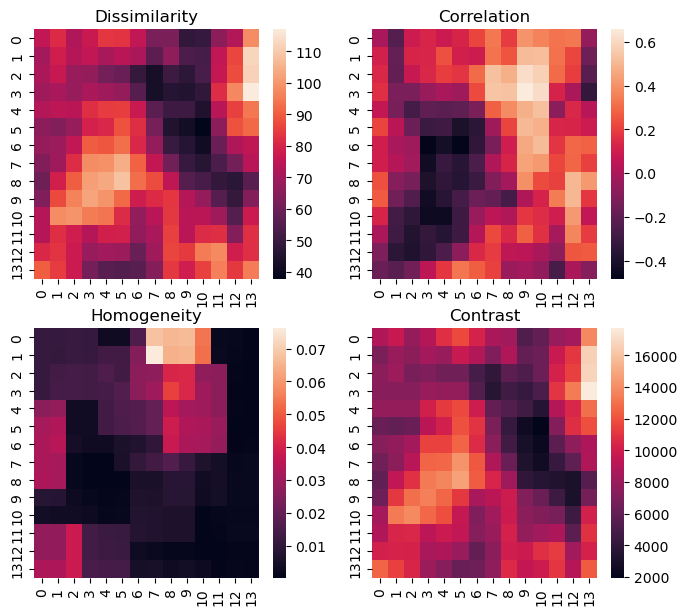

In [46]:
# not plot the results

band = band1

plt.figure(figsize=(8, 11))

plt.subplot(3,2,1)
sns.heatmap(band[...,0]).set_title('Dissimilarity')

plt.subplot(3,2,2)
sns.heatmap(band[...,1]).set_title('Correlation')

plt.subplot(3,2,3)
sns.heatmap(band[...,2]).set_title('Homogeneity')

plt.subplot(3,2,4)
sns.heatmap(band[...,3]).set_title('Contrast');

# plt.subplot(3,2,5)
# sns.heatmap(band[...,4]).set_title('ASM')

# plt.subplot(3,2,6)
# sns.heatmap(band[...,5]).set_title('Energy');

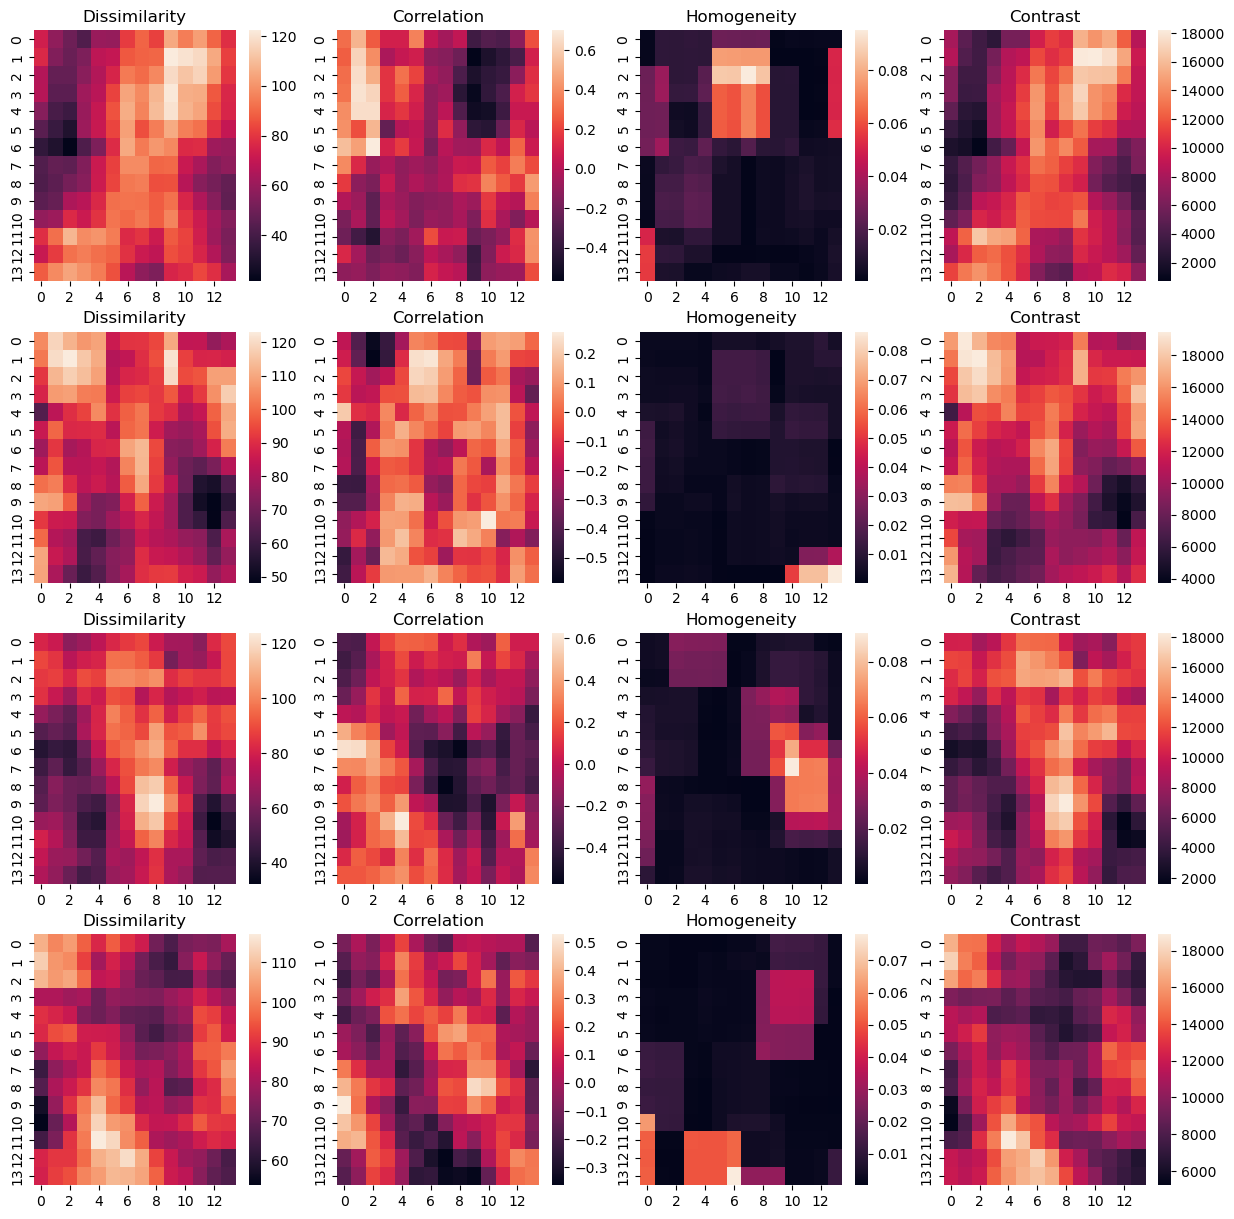

In [138]:
# ... for loop .....
arr = np.load('../data/train-texture/08002.npy')
plt.figure(figsize=(15, 15))

# blue
plt.subplot(4,4,1)
sns.heatmap(arr[...,0]).set_title('Dissimilarity')

plt.subplot(4,4,2)
sns.heatmap(arr[...,1]).set_title('Correlation')

plt.subplot(4,4,3)
sns.heatmap(arr[...,2]).set_title('Homogeneity')

plt.subplot(4,4,4)
sns.heatmap(arr[...,3]).set_title('Contrast')

# green
plt.subplot(4,4,5)
sns.heatmap(arr[...,4]).set_title('Dissimilarity')

plt.subplot(4,4,6)
sns.heatmap(arr[...,5]).set_title('Correlation')

plt.subplot(4,4,7)
sns.heatmap(arr[...,6]).set_title('Homogeneity')

plt.subplot(4,4,8)
sns.heatmap(arr[...,7]).set_title('Contrast');

# red
plt.subplot(4,4,9)
sns.heatmap(arr[...,8]).set_title('Dissimilarity')

plt.subplot(4,4,10)
sns.heatmap(arr[...,9]).set_title('Correlation')

plt.subplot(4,4,11)
sns.heatmap(arr[...,10]).set_title('Homogeneity')

plt.subplot(4,4,12)
sns.heatmap(arr[...,11]).set_title('Contrast')

# nir
plt.subplot(4,4,13)
sns.heatmap(arr[...,12]).set_title('Dissimilarity')

plt.subplot(4,4,14)
sns.heatmap(arr[...,13]).set_title('Correlation')

plt.subplot(4,4,15)
sns.heatmap(arr[...,14]).set_title('Homogeneity')

plt.subplot(4,4,16)
sns.heatmap(arr[...,15]).set_title('Contrast');

In [1]:
def multiplot(matrices, nrows = 13, ncols = 6):
    '''Docstring
    
         Parameters:
          matrices (list):
          nrows (int):
          
         Returns:
          None
    '''
    fig, axs = plt.subplots(ncols = ncols, nrows = nrows)
    fig.set_size_inches(18, 3.25*nrows)
    to_iter = [[x for x in range(i, i + ncols + 1)] for i in range(0, nrows*ncols, ncols)]
    counter = 0
    for r in range(1, nrows + 1):
        min_i = min(to_iter[r-1])
        max_i = max(to_iter[r-1])
        for i in range(ncols):
            sns.heatmap(data = matrices[..., counter], ax = axs[r - 1, i], cbar = False,
                       cmap = sns.color_palette("viridis", as_cmap=True))
            axs[r - 1, i].set_xlabel("")
            axs[r - 1, i].set_ylabel("")
            axs[r - 1, i].set_yticks([])
            axs[r - 1, i].set_xticks([])
            counter += 1
    plt.show

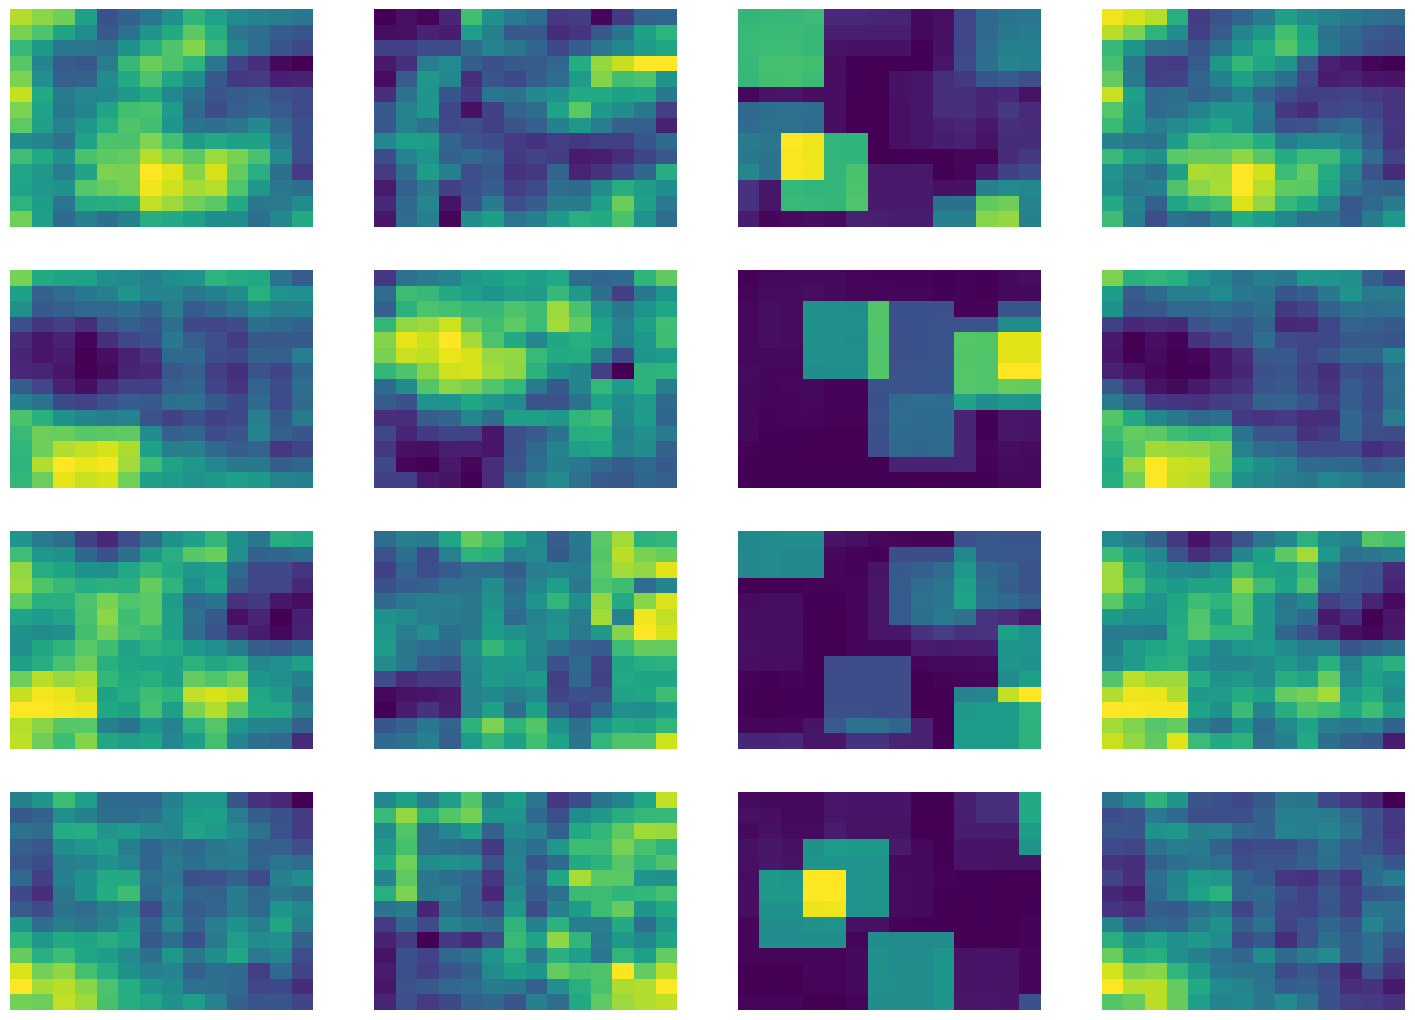

In [4]:
arr = np.load('../data/train-texture/08004.npy')
multiplot(arr, 4, 4)

### Deployment pipeline prototyping

In [79]:
x = '1671'
y = '1092'
folder = f"../tmp/ashanti/{str(x)}/{str(y)}/"
tile_str = f'{str(x)}X{str(y)}Y'
s2_10_file = f'{folder}raw/s2_10/{tile_str}.hkl'
s2_20_file = f'{folder}raw/s2_20/{tile_str}.hkl'
s2_10 = hkl.load(s2_10_file)
s2_20 = hkl.load(s2_20_file)
s2_10.shape, s2_20.shape

((10, 618, 613, 4), (10, 309, 307, 7))

In [80]:
# Ensure arrays are the same dims
width = s2_20.shape[1] * 2
height = s2_20.shape[2] * 2
width, height

(618, 614)

In [81]:
s2_10 = adjust_shape(s2_10, width, height)
s2_10.shape

(10, 618, 614, 4)

In [85]:
def process_txt_feats(s2):
    
    '''
    Takes in a (x, x, 10) s2 array and performs texture analysis
    on all four bands. Returns a () array
    '''
    s2 = img_as_ubyte(s2)
    assert s2.dtype == np.uint8, print(s2.dtype)
    
    blue = s2[..., 0]
    green = s2[..., 1]
    red = s2[..., 2]
    nir = s2[..., 3]
    output = np.zeros((14, 14, 16))
    
    output[..., 0:4] = extract_texture(blue)
    output[..., 4:8] = extract_texture(green)
    output[..., 8:12] = extract_texture(red)
    output[..., 12:16] = extract_texture(nir)
    
    print(f'texture is {output.shape}')
    
    return output

In [91]:
from skimage.util import img_as_ubyte

In [ ]:
## perform the texture analysis on a processed and unprocessed tile, visualize the results

In [86]:
process_txt_feats((1671, 1092), '../tmp/ashanti')

((10, 618, 614, 4), dtype('uint8'))

## Exploring Window Sizes

(618, 610)

dtype('uint8')

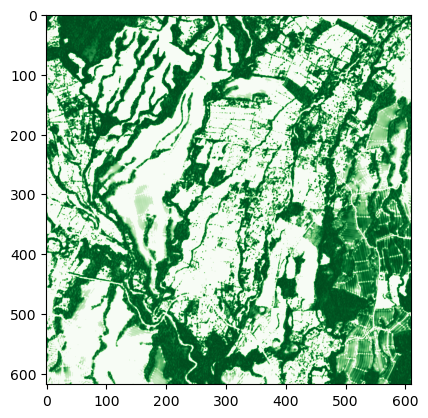

In [8]:
# select an image to work with
img = rs.open('../tmp/tml_preds/479X1129Y_FINAL.tif').read(1)
display(img.shape, img.dtype)
show(img, cmap='Greens');

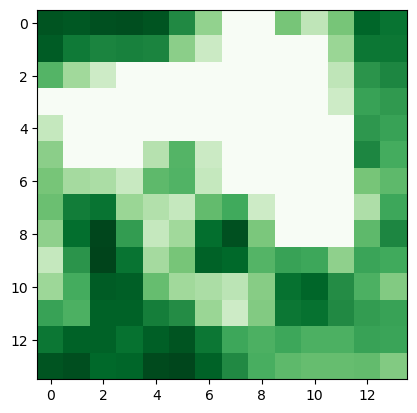

In [10]:
# this is a 14x14 plot
test = img[510:524, 510:524]
show(test, cmap='Greens');

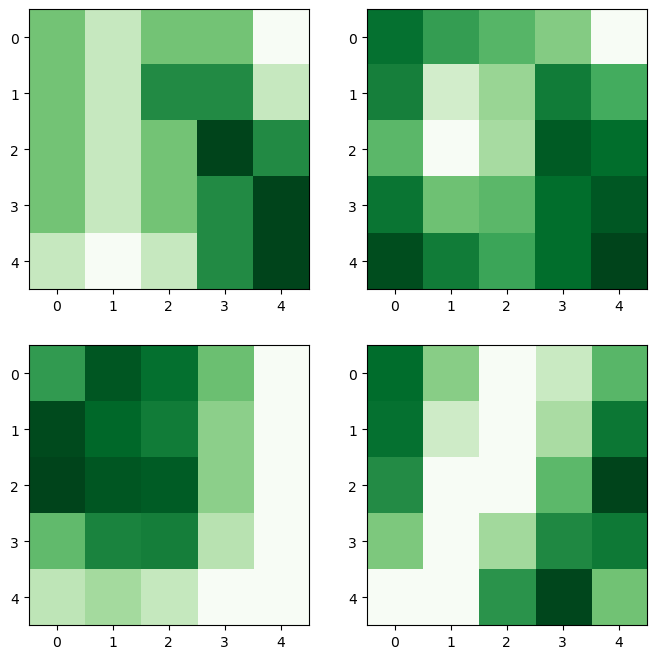

In [11]:
# select 5x5 windows
loc1 = img[500:505, 500:505]
loc2 = img[400:405, 500:505]
loc3 = img[200:205, 500:505]
loc4 = img[100:105, 500:505]
patches = [loc1, loc2, loc3, loc4]

plt.figure(figsize=(8,8))

for i, patch in enumerate(patches):
    ax = plt.subplot(2, 2, i + 1)
    show(patch, cmap='Greens', ax=ax)

In [102]:
# test if the training pipeline works

X, y = pp.create_xy(['v08', 'v14', 'v15'], 
                    classes='multi', 
                    drop_prob=False, 
                    drop_feats=False, 
                    feature_select=[], 
                    verbose=False)

37.0 plots labeled unknown were dropped.
Plot id 08012 has no cloud free imagery and will be removed.
Plot id 08039 has no cloud free imagery and will be removed.
Plot id 08114 has no cloud free imagery and will be removed.
Plot id 08124 has no cloud free imagery and will be removed.
Plot id 08170 has no cloud free imagery and will be removed.
Plot id 08181 has no cloud free imagery and will be removed.
Plot id 08204 has no cloud free imagery and will be removed.
Plot id 08214 has no cloud free imagery and will be removed.
Plot id 08216 has no cloud free imagery and will be removed.
Plot id 08223 has no cloud free imagery and will be removed.
53.0 plots labeled unknown were dropped.
Plot id 14027 has no cloud free imagery and will be removed.
2.0 plots labeled unknown were dropped.
Training data includes 421 plots.


100%|██████████████████████████████████████████████████████████████████████████████████████████| 421/421 [6:57:29<00:00, 59.50s/it]

Class count {0.0: 14223, 1.0: 13566, 2.0: 54727}


In [104]:
X_train_ss, X_test_ss, y_train, y_test = pp.reshape_and_scale_manual(X, y, 'v15_txt')

In [105]:
# train the catboost multiclassifier
y_test, pred, probs, probs_pos = rp.fit_eval_multiclassifier(X_train_ss, 
                                                             X_test_ss, 
                                                             y_train, 
                                                             y_test, 
                                                             'cat','v15_txt_scaled')

In [106]:
df = pd.read_csv('../models/mvp_scores.csv')
df[df['class'] == 'multi']

,model,class,feats,cv,train_score,test_score,roc_auc,precision,recall,f1,date
60,cat_v15,multi,65.0,0.9189,0.9951,0.9126,0.8323,0.9425,0.9601,0.9513,1/20/23
61,cat_v15,multi,65.0,0.8835,0.9930,0.8905,NaN,0.8823,0.8905,0.8860,1/20/23
62,cat_v15,multi,65.0,0.8716,0.9916,0.8639,NaN,0.8817,0.8639,0.8711,1/24/23
64,cat_v15,multi,NaN,0.8716,0.9916,0.8639,NaN,0.8817,0.8639,0.8711,1/24/23
96,cat_v15,multi,NaN,0.8269,0.9807,0.7970,NaN,0.7937,0.7970,0.7945,3/21/23
102,cat_v15_txt,multi,81.0,0.8272,0.9821,0.7946,NaN,0.7910,0.7946,0.7919,2023-04-03
105,cat_v15_txt_scaled,multi,81.0,0.8265,0.9830,0.7996,NaN,0.7960,0.7996,0.7969,2023-04-04


In [108]:
df.tail(10)

,model,class,feats,cv,train_score,test_score,roc_auc,precision,recall,f1,date
96,cat_v15,multi,NaN,0.8269,0.9807,0.7970,NaN,0.7937,0.7970,0.7945,3/21/23
97,cat_v17,binary,65.0,0.8901,0.9815,0.8918,0.9470,0.9254,0.9185,0.9220,3/21/23
98,cat_v17_scaled,binary,65.0,0.8902,0.9820,0.8912,0.9472,0.9263,0.9166,0.9214,3/21/23
99,cat_v17_fs,binary,40.0,0.8879,0.9806,0.8916,0.9476,0.9273,0.9160,0.9216,3/21/23
100,cat_v17_tuned,binary,40.0,0.8872,0.9850,0.8911,0.9469,0.9243,0.9187,0.9215,3/21/23
101,cat_v17_tuned_nfs,binary,65.0,0.8882,0.9849,0.8915,0.9470,0.9237,0.9202,0.9219,3/22/23
102,cat_v15_txt,multi,81.0,0.8272,0.9821,0.7946,NaN,0.7910,0.7946,0.7919,2023-04-03
103,cat_v17_txt,binary,81.0,0.8894,0.9826,0.8916,0.9476,0.9259,0.9177,0.9218,2023-04-04
104,cat_v17_txt_scaled,binary,81.0,0.8894,0.9823,0.8897,0.9472,0.9247,0.9161,0.9204,2023-04-04
105,cat_v15_txt_scaled,multi,81.0,0.8265,0.9830,0.7996,NaN,0.7960,0.7996,0.7969,2023-04-04


## Resources
* https://www.aidancooper.co.uk/a-non-technical-guide-to-interpreting-shap-analyses/
* https://github.com/catboost/tutorials/blob/master/model_analysis/shap_values_tutorial.ipynb
* https://stackoverflow.com/questions/59746304/catboost-classifier-for-class-imbalance
* https://github.com/MartimChaves/glcm_sat_img/blob/main/my_glcm/my_glcm.py
* https://scikit-image.org/docs/stable/auto_examples/features_detection/plot_glcm.html#sphx-glr-auto-examples-features-detection-plot-glcm-py
* https://stackoverflow.com/questions/35551249/implementing-glcm-texture-feature-with-scikit-image-and-python